In [1]:
from fastai.vision import *
from fastai.tabular import *
from image_tabular.core import *
from image_tabular.dataset import *
from image_tabular.model import *
#from image_tabular.metric import *
import sklearn.metrics as metrics
from sklearn.metrics import f1_score
# use gpu by default if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print(len(train_df), len(test_df))
     

5035 2159


In [3]:
train_df.head()

,Unnamed: 0,INCIDENT_NO,LONGITUDE,LATITUDE,DAY,MONTH,YEAR,DATE,ZONING_CATEGORIES,HOUSES WITHIN 100 METER,...,TMIN,AWND,WDF2,WDF5,WSF2,WSF5,NEW_NDVI_VALUE,NEW_NEW_NDVI_VALUE,FIRE_ALARM,image_name
0,0,F191789187,-121.836504,37.279261,27,6,2019,6/27/2019,Road,31,...,55.0,10.74,340,320.0,21.9,28.0,246,227,1,F191789187_2019_6
1,1,F200239062,-121.841556,37.351582,23,1,2020,1/23/2020,Residential,2,...,45.0,2.24,330,330.0,8.9,11.0,176,123,2,F200239062_2020_1
2,2,F191709218,-121.851588,37.275038,19,6,2019,6/19/2019,Development,128,...,58.0,9.17,330,330.0,17.0,21.0,227,192,1,F191709218_2019_6
3,3,F191659097,-121.853330,37.322976,14,6,2019,6/14/2019,Residential,37,...,56.0,7.16,330,330.0,19.9,23.0,151,136,2,F191659097_2019_6
4,4,F193049078,-122.006150,37.326483,31,10,2019,10/31/2019,Road,0,...,42.0,3.58,330,310.0,10.1,12.1,234,63,3,F193049078_2019_10


In [4]:
train_df["FIRE_ALARM"].value_counts(normalize=True)

1    0.667329
2    0.198808
3    0.133863
Name: FIRE_ALARM, dtype: float64

In [5]:
tfms = get_transforms(flip_vert=True)
size = 62

In [6]:
train_df.columns

Index(['Unnamed: 0', 'INCIDENT_NO', 'LONGITUDE', 'LATITUDE', 'DAY', 'MONTH',
       'YEAR', 'DATE', 'ZONING_CATEGORIES', 'HOUSES WITHIN 100 METER',
       'HOUSES WITHIN 200 METER', 'OLD_NDVI_VALUE', 'PRCP', 'TMAX', 'TMIN',
       'AWND', 'WDF2', 'WDF5', 'WSF2', 'WSF5', 'NEW_NDVI_VALUE',
       'NEW_NEW_NDVI_VALUE', 'FIRE_ALARM', 'image_name'],
      dtype='object')

In [7]:
val_idx = get_valid_index(train_df)
len(val_idx)

1007

In [8]:
folder = r"C:/Users/sanja/OneDrive/Desktop/cnn_tab/CNN_ResNet_5"

In [9]:
cols = "INCIDENT_NO"

In [10]:
image_data = (ImageList.from_df(train_df, path=folder,cols="image_name",
                               folder="train_images", suffix=".png")
              .split_by_idx(val_idx)
              .label_from_df(cols="FIRE_ALARM")
              )

# add test data so that we can make predictions
test_image_data = ImageList.from_df(test_df, path=folder,cols="image_name",
                                    folder="test_images", suffix=".png")
image_data.add_test(test_image_data)

LabelLists;

Train: LabelList (4028 items)
x: ImageList
Image (3, 62, 62),Image (3, 62, 62),Image (3, 62, 62),Image (3, 62, 62),Image (3, 62, 62)
y: CategoryList
1,2,1,2,3
Path: C:\Users\sanja\OneDrive\Desktop\cnn_tab\CNN_ResNet_5;

Valid: LabelList (1007 items)
x: ImageList
Image (3, 62, 62),Image (3, 62, 62),Image (3, 62, 62),Image (3, 62, 62),Image (3, 62, 62)
y: CategoryList
1,1,3,1,1
Path: C:\Users\sanja\OneDrive\Desktop\cnn_tab\CNN_ResNet_5;

Test: LabelList (2159 items)
x: ImageList
Image (3, 62, 62),Image (3, 62, 62),Image (3, 62, 62),Image (3, 62, 62),Image (3, 62, 62)
y: EmptyLabelList
,,,,
Path: C:\Users\sanja\OneDrive\Desktop\cnn_tab\CNN_ResNet_5

2


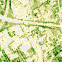

In [11]:
print(image_data.train[10][1])
image_data.train[10][0]

In [12]:
dep_var = 'FIRE_ALARM'
cat_names = ['ZONING_CATEGORIES']
cont_names = ['HOUSES WITHIN 200 METER', 'HOUSES WITHIN 100 METER', 'YEAR', 'MONTH', 'LONGITUDE', 'LATITUDE','TMAX','TMIN',
               'AWND', 'WDF2', 'WDF5', 'WSF2', 'WSF5', 'PRCP','DAY','NEW_NEW_NDVI_VALUE']
procs = [FillMissing, Categorify, Normalize]

In [13]:

tab_data = (TabularList.from_df(train_df, path=folder, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(val_idx)
                           .label_from_df(cols=dep_var))

# add test
tab_data.add_test(TabularList.from_df(test_df, cat_names=cat_names, cont_names=cont_names,
                                      processor = tab_data.train.x.processor))

LabelLists;

Train: LabelList (4028 items)
x: TabularList
ZONING_CATEGORIES Road; HOUSES WITHIN 200 METER 0.2829; HOUSES WITHIN 100 METER -0.2694; YEAR -0.6929; MONTH -0.1613; LONGITUDE 0.6245; LATITUDE -0.9798; TMAX -0.0264; TMIN 0.4098; AWND 1.6539; WDF2 0.6055; WDF5 0.3473; WSF2 1.0590; WSF5 1.0521; PRCP -0.1843; DAY 1.3192; NEW_NEW_NDVI_VALUE 1.0566; ,ZONING_CATEGORIES Residential; HOUSES WITHIN 200 METER -0.4905; HOUSES WITHIN 100 METER -0.6854; YEAR -0.0357; MONTH -1.6956; LONGITUDE 0.5202; LATITUDE 0.6578; TMAX -1.0600; TMIN -0.8191; AWND -1.7095; WDF2 0.4313; WDF5 0.4633; WSF2 -1.8375; WSF5 -1.7443; PRCP -0.1843; DAY 0.8623; NEW_NEW_NDVI_VALUE -0.8425; ,ZONING_CATEGORIES Development; HOUSES WITHIN 200 METER 0.5970; HOUSES WITHIN 100 METER 1.1220; YEAR -0.6929; MONTH -0.1613; LONGITUDE 0.3132; LATITUDE -1.0755; TMAX 0.4434; TMIN 0.7785; AWND 1.0326; WDF2 0.4313; WDF5 0.4633; WSF2 -0.0328; WSF5 -0.0994; PRCP -0.1843; DAY 0.4054; NEW_NEW_NDVI_VALUE 0.4175; ,ZONING_CATEGORIES Resid

In [14]:
tab_data.train[0]

(TabularLine [tensor([6]), tensor([ 0.2829, -0.2694, -0.6929, -0.1613,  0.6245, -0.9798, -0.0264,  0.4098,
          1.6539,  0.6055,  0.3473,  1.0590,  1.0521, -0.1843,  1.3192,  1.0566])],
 Category 0)

In [15]:
integrate_train, integrate_valid, integrate_test = get_imagetabdatasets(image_data, tab_data)


In [16]:
bs = 64

db = DataBunch.create(integrate_train, integrate_valid, integrate_test,
                      path=folder, bs=bs)
db


DataBunch;

Train: <image_tabular.dataset.ImageTabDataset object at 0x000001C0EA45C4C0>;

Valid: <image_tabular.dataset.ImageTabDataset object at 0x000001C0EA45C310>;

Test: <image_tabular.dataset.ImageTabDataset object at 0x000001C0EA45C640>

In [17]:
db.norm, db.denorm = normalize_funcs_image_tab(*imagenet_stats)
db.add_tfm(db.norm)

In [18]:
## Training on image and tabular data 

In [19]:
x, y = next(iter(db.train_dl))
len(x)

2

In [20]:
x[0].shape

torch.Size([64, 3, 62, 62])

In [21]:
cnn_arch = models.resnet50

# cnn_out_sz is the output size of the cnn model that will be concatenated with tabular model output
cnn_out_sz = 32

# use fastai functions to get a cnn model
image_data_db = image_data.databunch()
image_data_db.c = cnn_out_sz
cnn_learn = cnn_learner(image_data_db, cnn_arch, ps=0.2)
cnn_model = cnn_learn.model

C:\Users\sanja\anaconda3\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\sanja\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
emb_szs = tab_data.train.get_emb_szs()

# output size of the tabular model that will be concatenated with cnn model output
tab_out_sz = 8

# use fastai functions to get a tabular model
tabular_model = TabularModel(emb_szs, len(cont_names), out_sz=tab_out_sz, layers=[8], ps=0.2)
tabular_model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(7, 5)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=21, out_features=8, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=8, out_features=8, bias=True)
  )
)

In [23]:
integrate_model = CNNTabularModel(cnn_model,
                                  tabular_model,
                                  layers = [cnn_out_sz + tab_out_sz, 32],
                                  ps=0.2,
                                  out_sz=3).to(device)

In [24]:
integrate_model(*x).shape

torch.Size([64, 3])

In [25]:
train_df['FIRE_ALARM'].value_counts()

1    3360
2    1001
3     674
Name: FIRE_ALARM, dtype: int64

In [26]:
weights = [1 - (train_df['FIRE_ALARM'].value_counts()[1]/len(train_df)), 1 - (train_df['FIRE_ALARM'].value_counts()[2]/len(train_df)), 1 - (train_df['FIRE_ALARM'].value_counts()[3]/len(train_df))]

In [27]:
#weights = [1/(1-train_df["FIRE_ALARM"].mean()), 1/(1-train_df["FIRE_ALARM"].mean()), 1/(1-train_df["FIRE_ALARM"].mean())]
loss_func = CrossEntropyFlat(weight=torch.FloatTensor(weights).to(device), ignore_index = 2)

In [28]:
weights

[0.33267130089374375, 0.8011916583912612, 0.8661370407149951]

In [29]:
learn = Learner(db, integrate_model, metrics=[accuracy], loss_func=loss_func)

In [30]:
learn.layer_groups = [nn.Sequential(*flatten_model(cnn_learn.layer_groups[0])),
                      nn.Sequential(*flatten_model(cnn_learn.layer_groups[1])),
                      nn.Sequential(*(flatten_model(cnn_learn.layer_groups[2]) +
                                      flatten_model(integrate_model.tabular_model) +
                                      flatten_model(integrate_model.layers)))]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


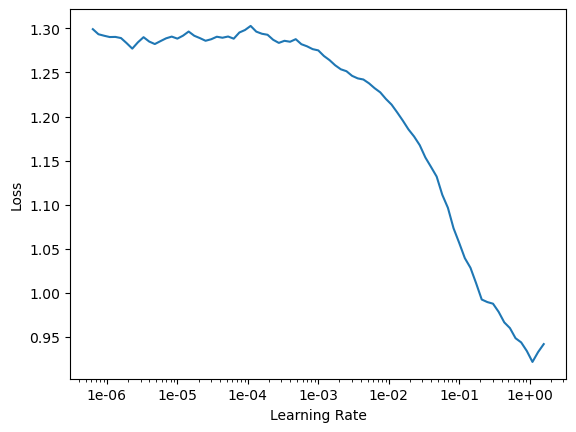

In [31]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.633514,0.239623,0.805362,04:44
1,0.368459,0.342099,0.748759,04:53
2,0.355753,0.252616,0.792453,04:47
3,0.324536,0.229718,0.809335,04:42
4,0.300832,0.180283,0.782522,04:39
5,0.293647,0.137976,0.827210,04:42
6,0.281771,0.156074,0.831182,04:40
7,0.254798,0.125141,0.841112,04:46
8,0.224968,0.119378,0.824230,04:09
9,0.209430,0.107622,0.838133,03:08


In [33]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5, 1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,0.237650,0.116055,0.836147,03:55
1,0.306439,0.240748,0.765640,03:41
2,0.290166,0.180310,0.825223,03:45
3,0.248087,0.119797,0.833168,03:38
4,0.219267,0.117664,0.813307,03:41


In [34]:
preds, y = learn.get_preds(DatasetType.Test)

In [35]:
preds

tensor([[9.0395e-01, 9.5999e-02, 4.9490e-05],
        [3.4686e-02, 9.6531e-01, 8.7990e-06],
        [9.9905e-01, 9.4528e-04, 1.0848e-07],
        ...,
        [9.9837e-01, 1.6276e-03, 2.8106e-07],
        [9.9412e-01, 5.8739e-03, 2.0277e-06],
        [1.2545e-07, 1.0000e+00, 1.8132e-19]])

In [36]:
learn.save("CNN_hypertuned")

In [37]:
import torch
a = preds.tolist()
# b = preds1.tolist()

In [38]:
 df = pd.DataFrame(a)
# df1 =pd.DataFrame(b)

In [39]:
df.to_csv('y_preds_hy_3.csv')
# df1.to_csv('preds1_multiclass_hy.csv') 